   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slop

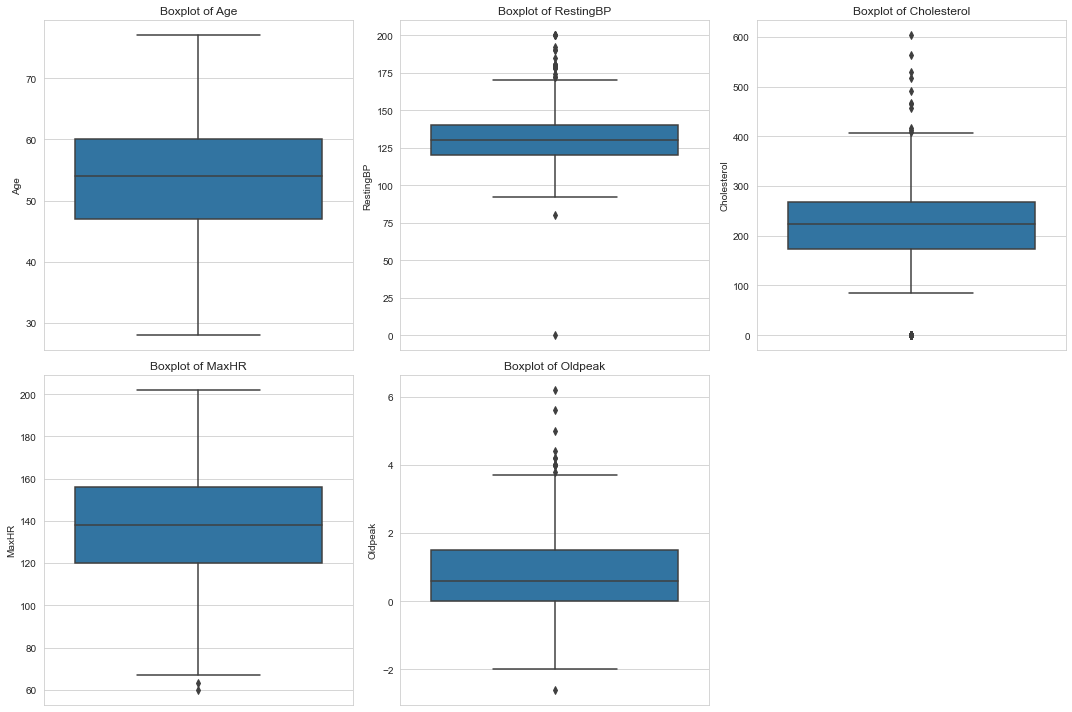

          Age  RestingBP  Cholesterol     MaxHR   Oldpeak
76  -2.281723  -0.778019     3.020369 -0.267596 -0.832432
109 -1.539213   3.113018     0.386011 -1.210752 -0.832432
149  0.051881  -0.129513     3.697252 -0.464087  0.105664
166 -0.372411   0.410909     0.294540  0.125386  3.858047
241  0.051881   3.653439    -0.007314  0.203982  1.043759
324 -0.796702  -1.750778    -1.818435 -0.149701 -3.271482
365  1.112610   3.653439    -1.818435  0.125386  0.105664
390 -0.266338   0.410909    -1.818435 -3.018469 -0.832432
399  0.794391   3.653439    -1.818435 -2.625487 -0.832432
449  0.157954  -7.154995    -1.818435  0.714859  0.574711
592  0.794391   3.113018     0.806776  0.518368  1.043759
616  1.430829  -0.940145     3.340516  0.911350  0.668521
702  0.582246   2.464511     0.651276  0.321877  3.107570
732  0.264027   3.653439     0.815923 -0.149701  2.919951
759  0.051881   3.221102     0.770188  2.286787 -0.832432
771  0.157954   0.410909     0.166481 -1.014262  4.420905
791 -0.266338 

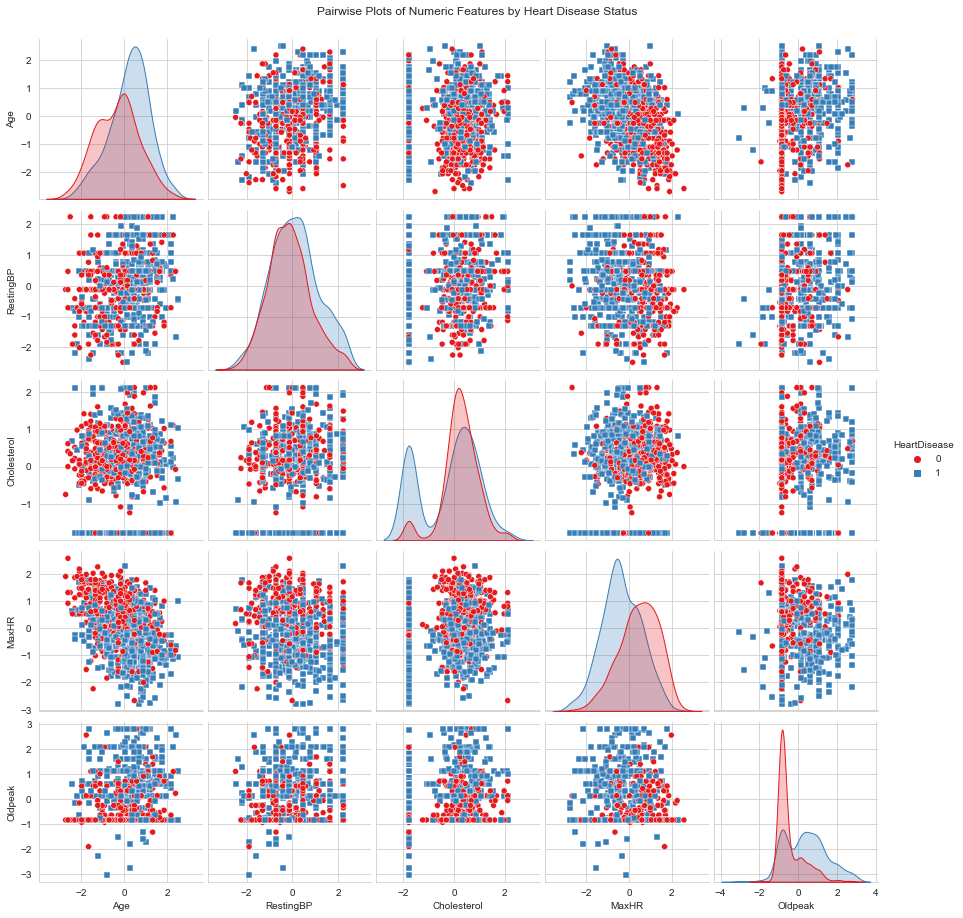

(734, 20) (184, 20) (734,) (184,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.8641304347826086               precision    recall  f1-score   support

           0       0.84      0.83      0.84        77
           1       0.88      0.89      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



<Figure size 720x576 with 0 Axes>

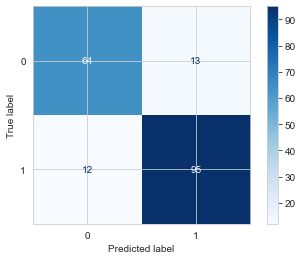

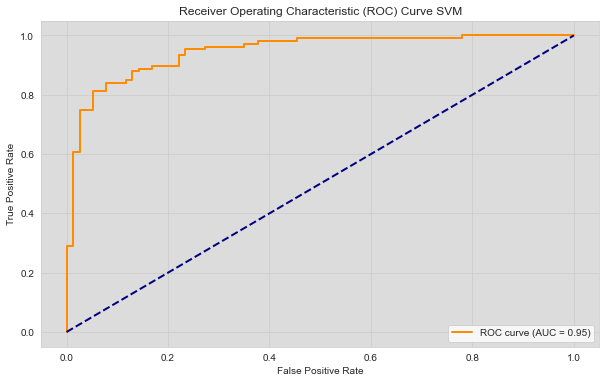

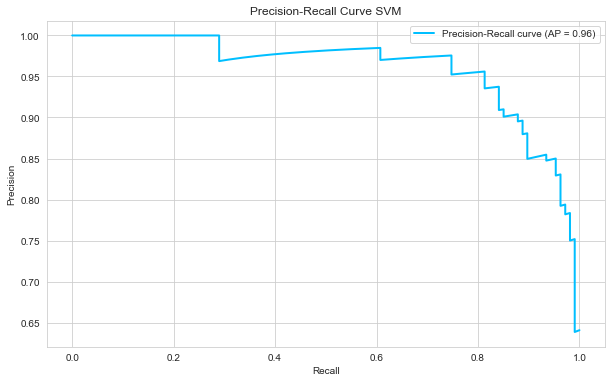

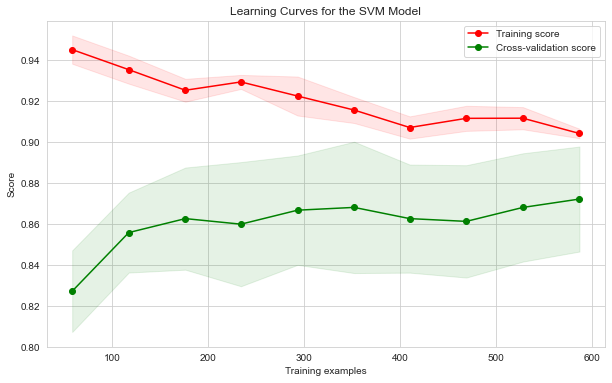

In [28]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             roc_curve, auc, precision_recall_curve, average_precision_score,
                             ConfusionMatrixDisplay)
from mpl_toolkits.mplot3d import Axes3D

# Load the data
heart_data = pd.read_csv("heart.csv")

# Display the first few rows of the dataset
print(heart_data.head())

# Check for missing values and data types
missing_values = heart_data.isnull().sum()
data_types = heart_data.dtypes
print(missing_values, data_types)

# Boxplot for numeric columns
plt.figure(figsize=(15, 10))
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=heart_data[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Z-scores for outlier detection
z_scores = zscore(heart_data[numeric_cols])
z_scores_df = pd.DataFrame(z_scores, columns=numeric_cols)
outliers = z_scores_df[(z_scores_df.abs() > 3).any(axis=1)]
print(outliers)

# Cap/Floor outliers based on IQR
for col in numeric_cols:
    Q1 = heart_data[col].quantile(0.25)
    Q3 = heart_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    heart_data[col] = heart_data[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
print(heart_data.describe())

# One-hot encode categorical columns
heart_data_encoded = pd.get_dummies(heart_data, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
print(heart_data_encoded.head())

# Scale the numeric columns
scaler = StandardScaler()
numeric_cols_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
heart_data_encoded[numeric_cols_to_scale] = scaler.fit_transform(heart_data_encoded[numeric_cols_to_scale])
print(heart_data_encoded.head())

# Generate pairwise plots
subset_data = heart_data_encoded[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']]
pairwise_plots = sns.pairplot(subset_data, hue='HeartDisease', markers=["o", "s"], palette="Set1")
plt.suptitle("Pairwise Plots of Numeric Features by Heart Disease Status", y=1.02)
plt.show()

# Splitting the data
X = heart_data_encoded.drop('HeartDisease', axis=1)
y = heart_data_encoded['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Grid search for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)



# Model evaluation
svm_best = SVC(**best_params)
svm_best.fit(X_train, y_train)
y_pred = svm_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(accuracy, class_report)

# Visualizing confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_best.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set the Seaborn style for the background
sns.set_style("whitegrid")

# ROC Curve
y_prob_positive = svm_best.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

# Set the background color
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))  # You can adjust the value inside coolwarm() as needed

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve SVM')
plt.legend(loc="lower right")
plt.show()


# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_positive)
average_precision = average_precision_score(y_test, y_prob_positive)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='deepskyblue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVM')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Learning Curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, test_scores = learning_curve(svm_best, X_train, y_train, train_sizes=train_sizes, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curves for the SVM Model")
plt.legend(loc="best")
plt.grid(True)
plt.show()




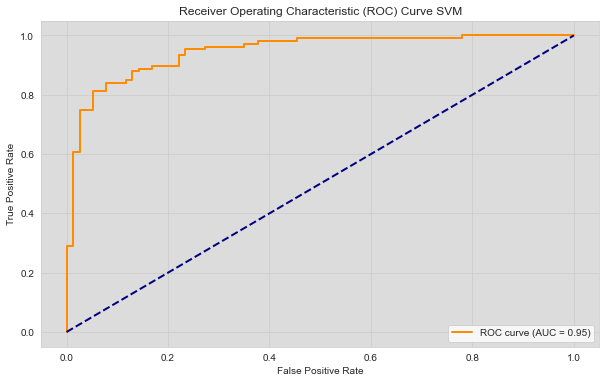

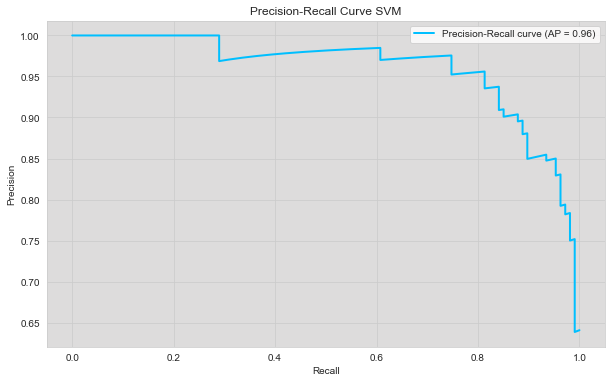

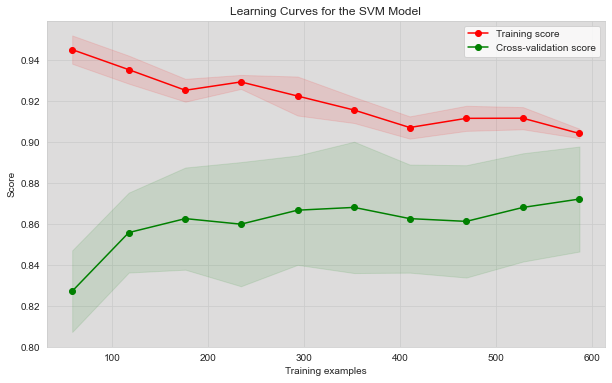

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set the Seaborn style for the background
sns.set_style("whitegrid")

# ROC Curve
y_prob_positive = svm_best.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

# Set the background color
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))  # You can adjust the value inside coolwarm() as needed

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve SVM')
plt.legend(loc="lower right")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Set the Seaborn style for the background
sns.set_style("whitegrid")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_positive)
average_precision = average_precision_score(y_test, y_prob_positive)

plt.figure(figsize=(10, 6))
# Set the background color for the Precision-Recall Curve
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))

plt.plot(recall, precision, color='deepskyblue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVM')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Assuming necessary libraries and data are imported for the learning curve
from sklearn.model_selection import learning_curve
import numpy as np

# Learning Curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, test_scores = learning_curve(svm_best, X_train, y_train, train_sizes=train_sizes, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
# Set the background color for the Learning Curve
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))

plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curves for the SVM Model")
plt.legend(loc="best")
plt.grid(True)
plt.show()


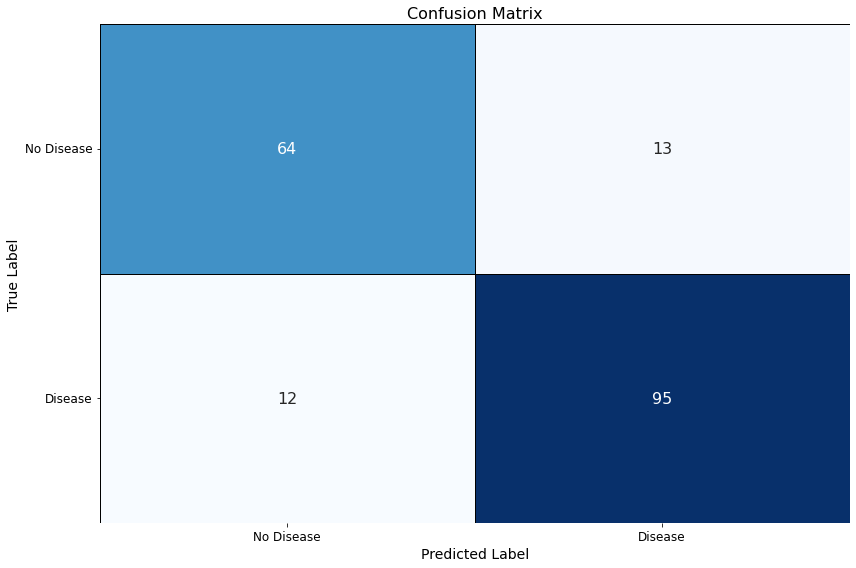

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are defined

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix with seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Assuming the labels are 'No Disease' and 'Disease' as per the code provided
plt.xticks(ticks=[0.5, 1.5], labels=['No Disease', 'Disease'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['No Disease', 'Disease'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


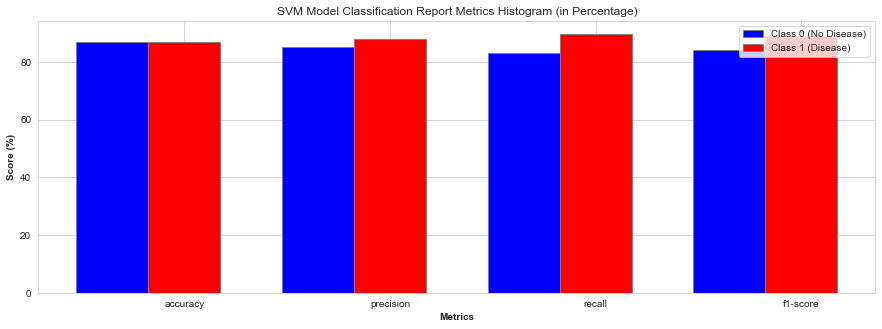

In [49]:
from sklearn.svm import SVC

# Assuming you've split the data into training and testing sets
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# Calculate the classification report for SVM
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

# Rearrange metrics to have 'accuracy' as the first metric
rearranged_metrics = ['accuracy', 'precision', 'recall', 'f1-score']

# Extract accuracy in percentage for SVM
svm_accuracy_percent = svm_report['accuracy'] * 100

# Extract and rearrange metrics for both classes for SVM
svm_class_0_metrics_rearranged = [svm_report['0'][metric] * 100 if metric != 'accuracy' else svm_accuracy_percent for metric in rearranged_metrics]
svm_class_1_metrics_rearranged = [svm_report['1'][metric] * 100 if metric != 'accuracy' else svm_accuracy_percent for metric in rearranged_metrics]

# Define the bar width and bar positions
barWidth = 0.35
r1_rearranged = np.arange(len(svm_class_0_metrics_rearranged))
r2_rearranged = [x + barWidth for x in r1_rearranged]

# Plotting the histogram with rearranged metrics for SVM
plt.figure(figsize=(15, 5))
plt.bar(r1_rearranged, svm_class_0_metrics_rearranged, width=barWidth, color='blue', edgecolor='grey', label='Class 0 (No Disease)')
plt.bar(r2_rearranged, svm_class_1_metrics_rearranged, width=barWidth, color='red', edgecolor='grey', label='Class 1 (Disease)')

plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(svm_class_0_metrics_rearranged))], rearranged_metrics)
plt.title('SVM Model Classification Report Metrics Histogram (in Percentage)')
plt.legend()
plt.show()

# If you want to plot the histogram again, you can use the same code as above without redefining the bar positions.


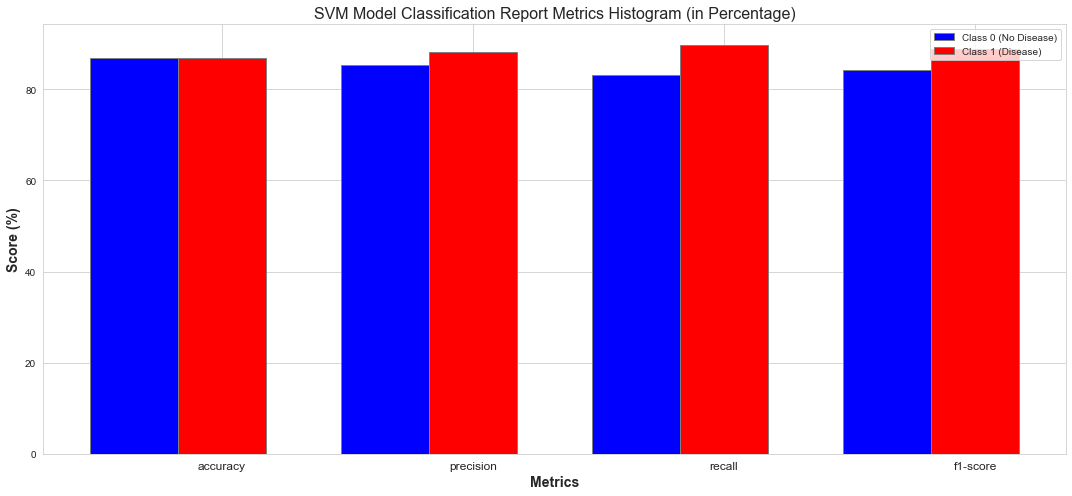

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Set the Seaborn style for the background
sns.set_style("whitegrid")

# Assuming you've split the data into training and testing sets
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# Calculate the classification report for SVM
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

# Rearrange metrics to have 'accuracy' as the first metric
rearranged_metrics = ['accuracy', 'precision', 'recall', 'f1-score']

# Extract accuracy in percentage for SVM
svm_accuracy_percent = svm_report['accuracy'] * 100

# Extract and rearrange metrics for both classes for SVM
svm_class_0_metrics_rearranged = [svm_report['0'][metric] * 100 if metric != 'accuracy' else svm_accuracy_percent for metric in rearranged_metrics]
svm_class_1_metrics_rearranged = [svm_report['1'][metric] * 100 if metric != 'accuracy' else svm_accuracy_percent for metric in rearranged_metrics]

# Define the bar width and bar positions
barWidth = 0.35
r1_rearranged = np.arange(len(svm_class_0_metrics_rearranged))
r2_rearranged = [x + barWidth for x in r1_rearranged]

# Plotting the histogram with rearranged metrics for SVM
plt.figure(figsize=(15, 7))
plt.bar(r1_rearranged, svm_class_0_metrics_rearranged, width=barWidth, color='blue', edgecolor='grey', label='Class 0 (No Disease)')
plt.bar(r2_rearranged, svm_class_1_metrics_rearranged, width=barWidth, color='red', edgecolor='grey', label='Class 1 (Disease)')

plt.xlabel('Metrics', fontweight='bold', fontsize=14)
plt.ylabel('Score (%)', fontweight='bold', fontsize=14)
plt.xticks([r + barWidth for r in range(len(svm_class_0_metrics_rearranged))], rearranged_metrics, fontsize=12)
plt.title('SVM Model Classification Report Metrics Histogram (in Percentage)', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


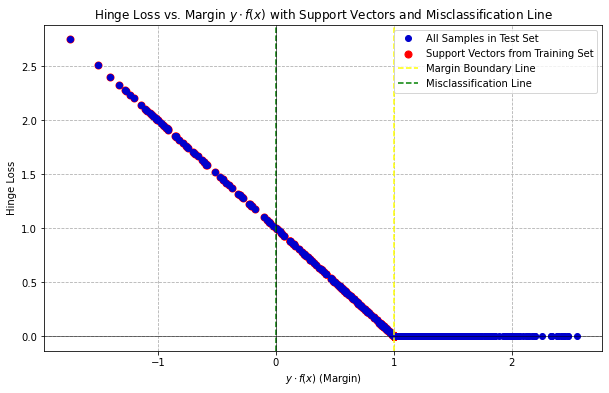

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ... [your SVM and dataset initialization code]

# Retrieve the support vector indices from the trained SVM model
support_vector_indices = svm_best.support_

# Retrieve the support vectors from the training set
support_vectors_train = X_train.iloc[support_vector_indices]

# Compute the decision function values (distance from the decision boundary) for the support vectors in the training set
support_vector_decision_values_train = svm_best.decision_function(support_vectors_train)

# Convert y_train for the support vectors to have values of -1 and 1
support_vector_y_train = y_train.iloc[support_vector_indices].apply(lambda x: 1 if x == 1 else -1)

# Compute the hinge loss for the support vectors in the training set
support_vector_hinge_loss_train = np.maximum(0, 1 - support_vector_y_train * support_vector_decision_values_train)

# Plotting hinge loss vs. margin with support vectors from the training set highlighted
plt.figure(figsize=(10, 6))
plt.plot(y_binary * decision_values, hinge_loss_values, 'o', color='mediumblue', label='All Samples in Test Set')
plt.scatter(support_vector_y_train * support_vector_decision_values_train, support_vector_hinge_loss_train, color='red', label='Support Vectors from Training Set', s=50)
plt.axvline(1, color='yellow', linestyle='--', label='Margin Boundary Line')  # Margin boundary line
plt.axvline(0, color='green', linestyle='--', label='Misclassification Line')
plt.xlabel('$y \cdot f(x)$ (Margin)')
plt.ylabel('Hinge Loss')
plt.title('Hinge Loss vs. Margin $y \cdot f(x)$ with Support Vectors and Misclassification Line')
plt.grid(True, which="both", ls="--")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()
plt.show()


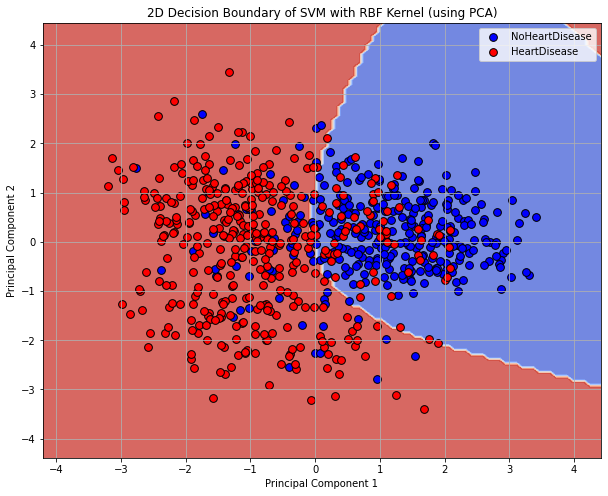

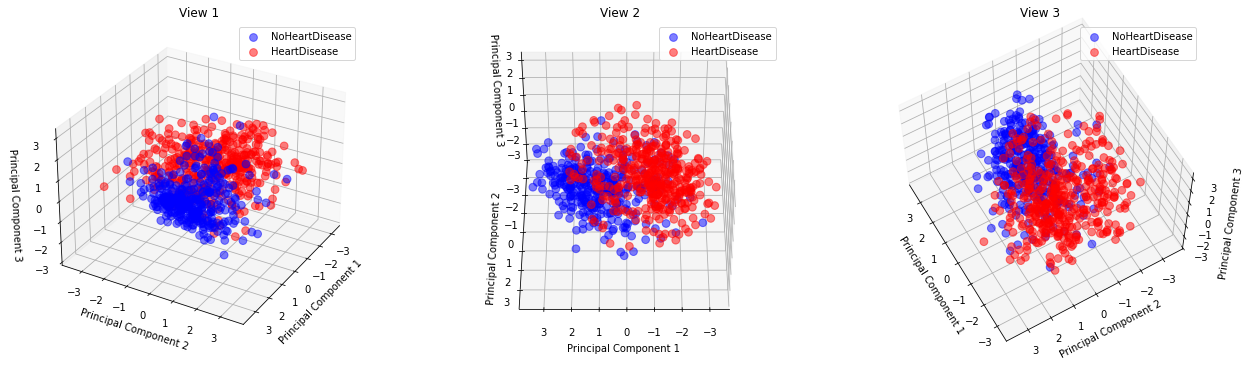

In [15]:
# PCA visualization in 2D
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)
svm_best.fit(X_train_pca_2d, y_train)
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = svm_best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca_2d[y_train==0, 0], X_train_pca_2d[y_train==0, 1], color='blue', s=60, label='NoHeartDisease', edgecolors='k')
plt.scatter(X_train_pca_2d[y_train==1, 0], X_train_pca_2d[y_train==1, 1], color='red', s=60, label='HeartDisease', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Decision Boundary of SVM with RBF Kernel (using PCA)')
plt.legend()
plt.grid(True)
plt.show()



# PCA visualization in 3D
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train)
X_test_pca_3d = pca_3d.transform(X_test)  # Transforming the test set
svm_best.fit(X_train_pca_3d, y_train)

fig = plt.figure(figsize=(18, 5))

# 3D visualization from different viewpoints
for idx, angle in enumerate([(30, 30), (45, 90), (60, 150)]):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    ax.scatter(X_train_pca_3d[y_train==0, 0], X_train_pca_3d[y_train==0, 1], X_train_pca_3d[y_train==0, 2], color='blue', s=60, label='NoHeartDisease', alpha=0.5)
    ax.scatter(X_train_pca_3d[y_train==1, 0], X_train_pca_3d[y_train==1, 1], X_train_pca_3d[y_train==1, 2], color='red', s=60, label='HeartDisease', alpha=0.5)
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'View {idx+1}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()

plt.tight_layout()
plt.show()



